In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

import json
import pickle

file_csv = 'ap2020_anonymized_cleaned_with_time.csv'
plt.style.use('bmh')

def get_timeframe(hour: int, minutes: int) -> str:
    return f'{hour:02}:{0 if minutes < 30 else 30 :02}'

df = df = pd.read_csv(file_csv)

df['datum a čas'] = df['datum a čas'].astype(np.datetime64)
df['time'] = df['time'].astype(np.datetime64)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4967 entries, 0 to 4966
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Unnamed: 0     4967 non-null   int64         
 1   číslo          4967 non-null   int64         
 2   ročník         4967 non-null   int64         
 3   datum a čas    4967 non-null   datetime64[ns]
 4   příjat         4967 non-null   object        
 5   důvod          4967 non-null   object        
 6   odeslán        4967 non-null   object        
 7   lékař          4967 non-null   object        
 8   vek            4967 non-null   int64         
 9   time           4967 non-null   datetime64[ns]
 10  hour           4967 non-null   int64         
 11  minute         4967 non-null   int64         
 12  weekday_index  4967 non-null   int64         
 13  week_number    4967 non-null   int64         
dtypes: datetime64[ns](2), int64(8), object(4)
memory usage: 543.4+ KB


### Prepare inputs and outputs

In [2]:
df['timeframe'] = df['time'].apply(lambda x: get_timeframe(x.hour, x.minute) )
df.head()

,Unnamed: 0,číslo,ročník,datum a čas,příjat,důvod,odeslán,lékař,vek,time,hour,minute,weekday_index,week_number,timeframe
0,0,20200001,46,2020-01-01 04:18:00,přes RZP/LSPP,bolest na hrudi,na oddělení KK,MUDr. Jan První,77,2023-03-03 04:18:00,4,18,2,1,04:00
1,1,20200002,83,2020-01-01 09:09:00,z ambulance KK IKEM,jiný,domácí ošetření,MUDr. Pavel Druhý,40,2023-03-03 09:09:00,9,9,2,1,09:00
2,2,20200003,72,2020-01-01 11:35:00,bez doporučení,palpitace,domácí ošetření,MUDr. Pavel Druhý,51,2023-03-03 11:35:00,11,35,2,1,11:30
3,3,20200004,99,2020-01-01 14:23:00,bez doporučení,bolest na hrudi,na oddělení KK,MUDr. Pavel Druhý,24,2023-03-03 14:23:00,14,23,2,1,14:00
4,4,20200005,28,2020-01-01 15:06:00,přes RZP/LSPP,jiný,na oddělení KK,MUDr. Pavel Druhý,95,2023-03-03 15:06:00,15,6,2,1,15:00


In [4]:
with open('timeframes_by_hour.json', 'r') as json_file:
    timeframe_cases_amounts = json.loads(json_file.read())

# we operate in 24-hour time
time_frames = [ f'{hour:02}:00' for hour in range(24) ]
    
#timeframe_cases_amounts
inputs_pd = df['hour'] #.apply(lambda x: time_frames.index(f'{x :02}:00') )
outputs_pd = inputs_pd.apply(lambda x: timeframe_cases_amounts[f'{x:02}:00'])

# reshape 
inputs = inputs_pd.to_numpy().reshape(-1, 1)
outputs = outputs_pd.to_numpy().reshape(-1, 1)

### Separate to train and test set

In [10]:
# Is this good idea if data are only from 1 year?
# Probably not
use_split = True
if use_split:
    X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, train_size=0.33, shuffle=False)
else:
    X_train, X_test, y_train, y_test = inputs, inputs, outputs, outputs
    
X_train.shape, y_train.shape

((1639, 1), (1639, 1))

In [20]:
model = Pipeline([('PolyFeatures', PolynomialFeatures(3)), ('LinRegression', LinearRegression())])
#model = LinearRegression()
res = model.fit(X_train , y_train)
print(f'Model score on train set: {res.score(X_train, y_train)}')
print(f'Model score on test set: {res.score(X_test, y_test)}')

Model score on train set: 0.6979460301641914
Model score on test set: 0.697148172998783


### Compare actual values and predicted values

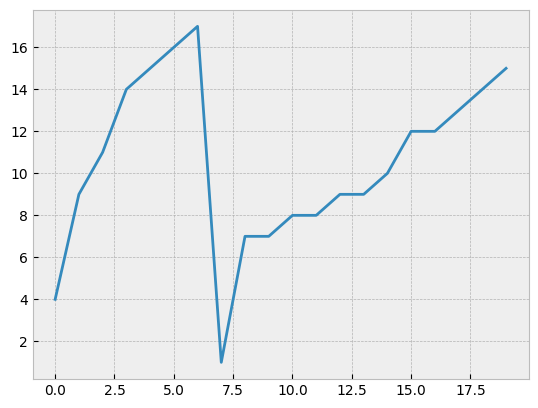

In [21]:
plt.plot(X_train[:20, :])

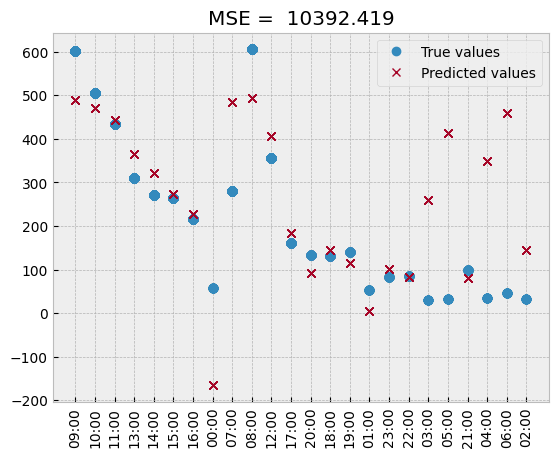

In [22]:
test_res = model.predict(X_test)

x_values = list(map(lambda index: time_frames[index], X_test.flatten()))
#x_values.sort()
y_test_values = y_test.flatten()
test_res_values = test_res.flatten()

mse = mean_squared_error(y_test_values, test_res_values)

plt.title(f'MSE = {mse : .3f}')
plt.plot(x_values, y_test_values, 'o')
plt.plot(x_values, test_res_values, 'x')
plt.legend(['True values', 'Predicted values'])
_ = plt.xticks(
    rotation=90,
    horizontalalignment='center'
)

### Save model

In [23]:
pickle.dump(model, open('our_model.pickle', "wb"))